# Z-Disc Classifier Training Tutorial

In this tutorial, we demonstrate how to train a Z-disc classifier using our code (introduced in [arXiv:2501.18714](https://arxiv.org/abs/2501.18714)).
The model accepts a three-channel input image—cropped and centered on a candidate object—and outputs a binary prediction indicating whether that object is a Z-disc.

In the paper, we present two distinct models:

1. **Multilayer Perceptron (MLP)**  
   Trained on a dataset of 6,000 manually labeled object crops.

2. **EfficientNetV2**  
   First trained (self-supervised) on over 2.5 million unlabeled object crops, then fine-tuned on those same 6,000 labeled images.

We begin with the MLP variant, as its architecture and training procedure are simpler to explain.


## MLP Training Procedure

Below we describe the steps used to train the MLP-based Z-disc classifier, using pretrained DINOv2 representations as inputs.

### 1. Load Pretrained DINOv2

- Use the `dinov2_vitl14_reg` checkpoint from the DINOv2 repository.
- This model accepts three-channel input crops and outputs a fixed-length representation vector.
- During MLP training, these DINOv2 vectors are used in place of raw pixel inputs.

### 2. Data Augmentation and Splitting

1. **Dataset Load**  
   - Start with all 6,000 labeled image crops (each a three-channel crop centered on a candidate object).

2. **Five Random Splits**  
   - For reproducibility, split the 6,000 images into training and test sets using five different random seeds.
   - Each seed yields its own train/test partition.

3. **Augmentation (Training Only)**  
   - For each training subset, apply:
     - Random rotations  
     - Horizontal flips  
   - Do **not** augment the test images; those remain unmodified.

### 3. Feature Extraction

- After augmentation (for training) or straightforward loading (for test), pass every crop through the `dinov2_vitl14_reg` model.
- Collect the resulting representation vectors along with their binary labels (0 = non–Z-disc, 1 = Z-disc).  
  - For each of the five splits, you will obtain:
    - A training set of DINOv2 feature vectors (one per augmented crop)  
    - A test set of DINOv2 feature vectors (one per unaugmented crop)

### 4. MLP Training and Evaluation

- **Inputs:** DINOv2 feature vectors paired with corresponding labels.  
- **Training Loop:**  
  1. For each split, initialize an MLP that takes a DINOv2 vector and outputs a probability.  
  2. Train the MLP on that split’s training vectors.  
  3. After each epoch (or training run), evaluate on the test split to measure test error.  
  4. Use the measured test error to tune:
     - Learning rate  
     - Regularization parameters  
  5. Save the best-performing MLP checkpoint for that split (i.e., the one with lowest test error).

- Repeat this process independently for all five random seeds.

### 5. Ensembling for Final Predictions

- After training five separate MLPs (one per split), combine them into an ensemble:
  1. For a new image crop, extract its DINOv2 representation vector.  
  2. Run that vector through each of the five saved MLP checkpoints to obtain five probability scores.  
  3. Aggregate those scores (for example, by averaging) to produce a final ensemble prediction.
  4. Use this ensemble output as the final Z-disc vs. non–Z-disc decision.



### Step 1: Data Preprocessing and Augmentation

Load the sample images and labels, split into train (80%) and test (20%) sets, then augment the training set by applying rotations (0°, 90°, 180°, 270°) and horizontal flips.


In [ ]:
# First, load a sample dataset of images and labels
import numpy as np

images = np.load('sample_data/sample_labeled_contours.npy')
labels = np.load('sample_data/sample_labels.npy')


# Next, split the images and labels into a training set (80%) and a test set (20%).
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2)


# Now, augment the training samples with rotations and horizontal flips.
augmented_images = []
augmented_labels = []

for img, lbl in zip(train_images, train_labels):
    # Rotate by 0°, 90°, 180°, 270°
    for k in range(4):
        rotated = np.rot90(img, k)
        augmented_images.append(rotated)
        augmented_labels.append(lbl)
        # Horizontal flip of the rotated image
        flipped = np.fliplr(rotated)
        augmented_images.append(flipped)
        augmented_labels.append(lbl)

augmented_images = np.stack(augmented_images, axis=0)
augmented_labels = np.array(augmented_labels)

### Step 2: DINOv2 Feature Extraction

Convert the augmented training images and test images into DINOv2 representation vectors by running `run_dinov2_feature_pipeline` on each dataset.


In [3]:
from classification.dino.feature_generator import run_dinov2_feature_pipeline

train_features = run_dinov2_feature_pipeline(augmented_images, batch_size=4)
test_features = run_dinov2_feature_pipeline(test_images, batch_size=4)

Using cache found in /home/ghost/.cache/torch/hub/facebookresearch_dinov2_main
/home/ghost/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ghost/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ghost/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Processing image 1/640 (first pass)...
Calculated Laplacian scaler (std): 0.0100
Preprocessing image 1/640 (second pass)...
Extracting features: 640/640


Using cache found in /home/ghost/.cache/torch/hub/facebookresearch_dinov2_main


Processing image 1/20 (first pass)...
Calculated Laplacian scaler (std): 0.0094
Preprocessing image 1/20 (second pass)...
Extracting features: 20/20


### Step 3: MLP Training

Below is a single function, `train_mlp_model`, that takes DINOv2 feature vectors and labels for training and testing, trains an MLP, prints epoch‐wise test accuracy, and saves the best checkpoint.


In [4]:
from classification.dino.mlp_classifier import train_mlp_model

trained_model = train_mlp_model(
    train_features,
    augmented_labels,
    test_features,
    test_labels,
    batch_size=8,
    num_epochs=50,
    learning_rate=1e-4,
    dropout_rate=0.5,
    weight_decay=1e-4,
)

Epoch 1/50 — Train Loss: 0.6615, Test Loss: 0.5323
Epoch 2/50 — Train Loss: 0.5932, Test Loss: 0.4926
Epoch 3/50 — Train Loss: 0.5142, Test Loss: 0.4432
Epoch 4/50 — Train Loss: 0.4728, Test Loss: 0.4360
Epoch 5/50 — Train Loss: 0.4356, Test Loss: 0.3934
Epoch 6/50 — Train Loss: 0.3863, Test Loss: 0.4058
Epoch 7/50 — Train Loss: 0.3443, Test Loss: 0.3957
Epoch 8/50 — Train Loss: 0.3199, Test Loss: 0.3848
Epoch 9/50 — Train Loss: 0.3283, Test Loss: 0.4007
Epoch 10/50 — Train Loss: 0.2549, Test Loss: 0.3876
Epoch 11/50 — Train Loss: 0.2573, Test Loss: 0.3633
Epoch 12/50 — Train Loss: 0.2655, Test Loss: 0.3441
Epoch 13/50 — Train Loss: 0.2266, Test Loss: 0.3727
Epoch 14/50 — Train Loss: 0.1882, Test Loss: 0.3385
Epoch 15/50 — Train Loss: 0.1915, Test Loss: 0.3048
Epoch 16/50 — Train Loss: 0.1756, Test Loss: 0.3788
Epoch 17/50 — Train Loss: 0.1551, Test Loss: 0.3253
Epoch 18/50 — Train Loss: 0.1547, Test Loss: 0.2766
Epoch 19/50 — Train Loss: 0.1320, Test Loss: 0.3470
Epoch 20/50 — Train L

### Step 4: Save Trained Model

Save the model’s state dictionary. During inference, we will use the checkpoints trained on the full 6000-sample dataset (available on GitHub) instead of this smaller 100-sample example.


In [5]:
import torch

torch.save(trained_model.state_dict(), "mlp_checkpoint_test.pth")

### Step 5: Inference on Test Images

Load the test images and run inference using the `infer_images` function with the trained MLP checkpoint to obtain logits.


In [12]:
import importlib
import classification.dino.mlp_classifier as mod

# After editing mlp_classifier.py (and saving), do:
importlib.reload(mod)

# And then rebind the function name:
from classification.dino.mlp_classifier import infer_zdisc_logits

In [13]:
from classification.dino.mlp_classifier import infer_zdisc_logits

# Run inference and obtain logits
logits = infer_zdisc_logits(test_images, "mlp_checkpoint_test.pth", batch_size=16)

# (Optional) Inspect the shape of the returned logits
print(f"Obtained logits with shape: {logits.shape}")

Received 20 images with shape (128, 128, 3).
Loading DINO model...


Using cache found in /home/ghost/.cache/torch/hub/facebookresearch_dinov2_main


Transforming images for DINO...
Processing image 1/20 (first pass)...
Calculated Laplacian scaler (std): 0.0094
Preprocessing image 1/20 (second pass)...
Extracting feature vectors with DINO...
Extracting features: 20/20
Loading trained MLP model...
Performing inference with MLP...
Obtained logits with shape: (20, 2)


### Visualize Predictions for 20 Test Sample 

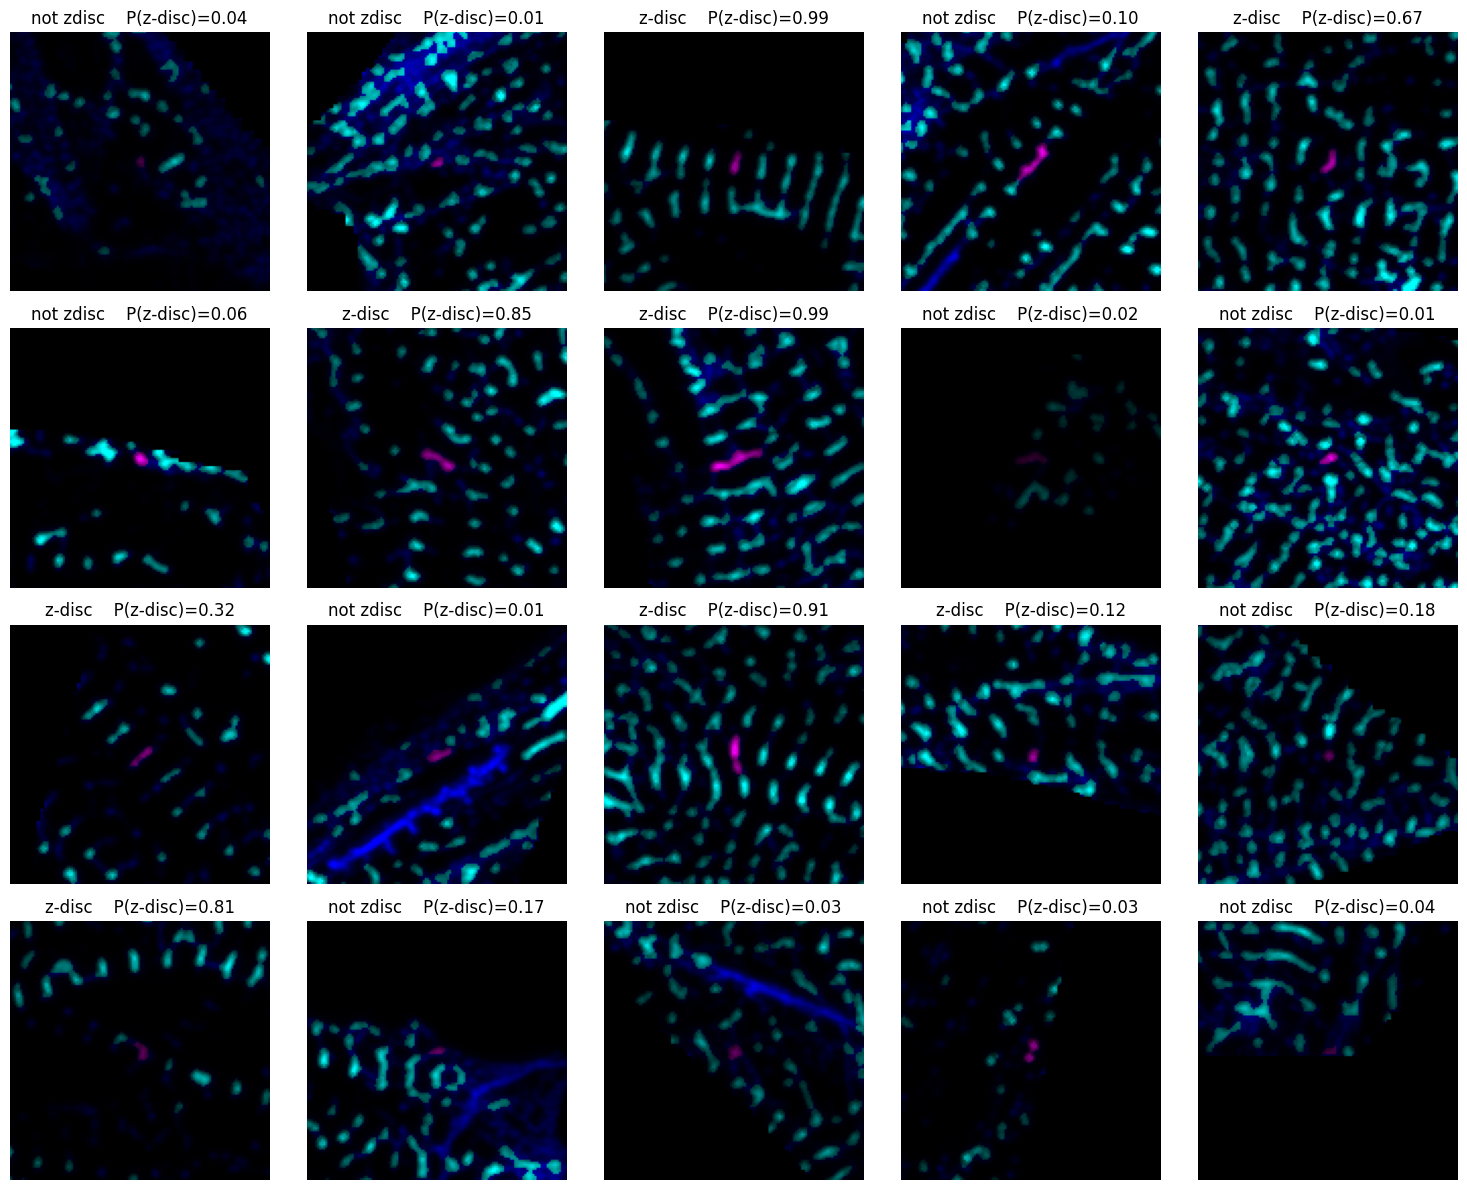

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Convert logits to probabilities for class “1” (z-disc).
probs = F.softmax(torch.from_numpy(logits), dim=1)[:, 1].numpy()

num_to_plot = 20
images_subset = test_images[:num_to_plot]
labels_subset = test_labels[:num_to_plot]
probs_subset = probs[:num_to_plot]

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    img = images_subset[idx]
    label = labels_subset[idx]
    prob = probs_subset[idx]
    label_str = "z-disc" if label == 1 else "not zdisc"
    
    ax.imshow(img)
    ax.set_title(f"{label_str}    P(z-disc)={prob:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## SimCLR Pretraining with EfficientNetV2-S

In this section we’ll show how to pretrain a SimCLR model using an EfficientNetV2-S backbone.  
We’ll walk through:

1. **Loading sample images**  
2. **Building a simple DataLoader + augmentation**  
3. **Defining hyperparameters inline**  
4. **Running the LightningModule**  
5. **Inspecting TensorBoard logs**

In [1]:
import numpy as np

if not hasattr(np, 'Inf'):
    np.Inf = np.inf

import torch
torch.set_float32_matmul_precision('medium')

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

from classification.simclr.pretraining.core    import Augment, ContrastiveLoss, SimCLRv2Model, convert_to_syncbn, param_groups
from classification.simclr.pretraining.trainer import SimCLRTrainer

/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1: Define Hyperparameters

List every setting here so nothing is hidden in external files.

In [2]:
# Config inline
class Config: pass
cfg = Config()

# data / model
cfg.img_size      = 128
cfg.batch_size    = 16

# training
cfg.epochs        = 10
cfg.seed          = 42
cfg.gradient_accumulation_steps = 1

# optimizer / loss
cfg.lr            = 0.3
cfg.momentum      = 0.9
cfg.weight_decay  = 1e-4
cfg.temperature   = 0.5
cfg.warmup_epochs = max(1, int(0.05*cfg.epochs))

### Step 2: Inline Dataset & DataLoader

We define a minimal `Dataset` right in the notebook.  
For your own data, just replace this class with any `torch.utils.data.Dataset`.


In [ ]:
# Simple Dataset + Loader
class SimpleImageDataset(Dataset):
    def __init__(self, arr):
        # expects float32 in [0,1] or uint8 in [0,255]
        self.images = arr.astype(np.float32)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, i):
        # return [C,H,W] tensor
        img = torch.tensor(self.images[i]).permute(2,0,1)
        return img

sample_images = np.load('sample_data/sample_labeled_contours.npy')
print("Loaded", sample_images.shape, "– swap in your own data here")

dataset = SimpleImageDataset(sample_images)
loader  = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True)

# normalization (for your data, set these appropriately)
cfg.mean          = np.mean(sample_images, axis=(0, 1, 2))
cfg.std           = np.std(sample_images, axis=(0, 1, 2))

Loaded (100, 128, 128, 3) – swap in your own data here


### Step 3: Instantiate Model & Trainer

We seed for reproducibility, build the LightningModule, and run training.  
By default TensorBoard logs go to `lightning_logs/`.


In [16]:
# Run pretraining
seed_everything(cfg.seed)
augment = Augment(cfg.img_size, cfg.mean, cfg.std)

# build and sync-BN the model
pl_module = SimCLRTrainer(cfg)

# 1) Best model (lowest epoch loss)
best_ckpt = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="simclr-pretrain-best-{train_loss_epoch:.2f}",
    monitor="train_loss_epoch",
    mode="min",
    save_top_k=1,
    save_last=False,
)

# Last epoch (with epoch number and final loss)
last_ckpt = ModelCheckpoint(
    dirpath="checkpoints/",
    # filename="simclr-pretrain-last-epoch{epoch:02d}-{train_loss_epoch:.2f}",
    save_top_k=0,     # we don’t track best here
    save_last=True,   # always keep the last
)

trainer = Trainer(
    max_epochs=cfg.epochs,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=1,
    callbacks=[best_ckpt, last_ckpt],
)

trainer.fit(pl_module, loader)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | SimCLRv2Model   | 21.2 M
1 | criterion | ContrastiveLoss | 0     
----------------------------------------------
21.2 M    Trainable params
0         Non-trainable params
21.2 M    Total params
84.655    Total estimated model params size (MB)


Using LARS optimizer | Learning Rate: 0.3 | Effective Batch Size: 16
Epoch 9: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s, loss=2.45, v_num=3, train_loss_step=1.110, train_loss_epoch=2.640]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s, loss=2.45, v_num=3, train_loss_step=1.110, train_loss_epoch=2.640]


In [18]:
best_path = best_ckpt.best_model_path
last_path = last_ckpt.last_model_path

best_loss = best_ckpt.best_model_score.item()
final_loss = float(trainer.callback_metrics["train_loss_epoch"])

print(f"SimCLR pretraining best checkpoint saved to:\n    {best_path}")
print(f"    (best train_loss_epoch = {best_loss:.2f})\n")
print(f"SimCLR pretraining last checkpoint saved to:\n    {last_path}")
print(f"    (last train_loss_epoch = {final_loss:.2f})")

SimCLR pretraining best checkpoint saved to:
    checkpoints/simclr-pretrain-best-train_loss_epoch=2.58.ckpt
    (best train_loss_epoch = 2.58)

SimCLR pretraining last checkpoint saved to:
    checkpoints/last-v1.ckpt
    (last train_loss_epoch = 2.64)


### Next

- Open TensorBoard to inspect your loss curves:
  ```bash
  tensorboard --logdir lightning_logs/


# Fine-tuning the Full EfficientNetV2 Network

Now that we have a pretrained EfficientNetV2 encoder + projection head, we’ll fine-tune **every layer** (backbone, proj head, and classifier) on our labeled images.  
We’ll walk through:

1. Loading labeled sample data  
2. Defining a simple Dataset & DataLoader  
3. Listing all hyperparameters inline  
4. Loading the pretrained backbone + proj layer weights  
5. Instantiating the `FineTuningTrainer` (which trains all parameters)  
6. Saving both best & last checkpoints  
7. Running `trainer.fit`  
8. Inspecting saved checkpoints 

In [1]:
# Imports & Sample Labeled Data
import numpy as np
if not hasattr(np, 'Inf'):
    np.Inf = np.inf

import torch
torch.set_float32_matmul_precision('medium')

from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

# your refactored finetuning modules
from classification.simclr.finetuning.core   import load_pretrained_backbone, FineTuneAugment
from classification.simclr.finetuning.trainer import FineTuningTrainer


/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step FT-1: Simple Dataset & DataLoader

Here’s a minimal inline `Dataset` that returns:
- **img**: a `[C,H,W]` float tensor  
- **label**: a single `long` class index

In [ ]:
# Define Dataset + DataLoader
class SimpleLabeledDataset(Dataset):
    def __init__(self, imgs, labels):
        self.images = imgs.astype(np.float32)
        self.labels = labels.astype(np.int64)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, i):
        img = torch.tensor(self.images[i]).permute(2,0,1)  # [H,W,C] → [C,H,W]
        label = torch.tensor(self.labels[i], dtype=torch.long)
        return img, label


# load images and integer labels
sample_images = np.load("sample_data/sample_labeled_contours.npy")
sample_labels = np.load("sample_data/sample_labels.npy")
print("Images:", sample_images.shape, "Labels:", sample_labels.shape)

dataset = SimpleLabeledDataset(sample_images, sample_labels)
loader  = DataLoader(dataset,
                     batch_size=64,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=True)
print("DataLoader ready with", len(loader), "batches")


Images: (6000, 128, 128, 3) Labels: (6000,)
DataLoader ready with 94 batches


## Step FT-2: Hyperparameters

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6369344..23.734528].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6108229..32.857338].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6369344..21.290916].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..83.0].
Clipping input data to the val

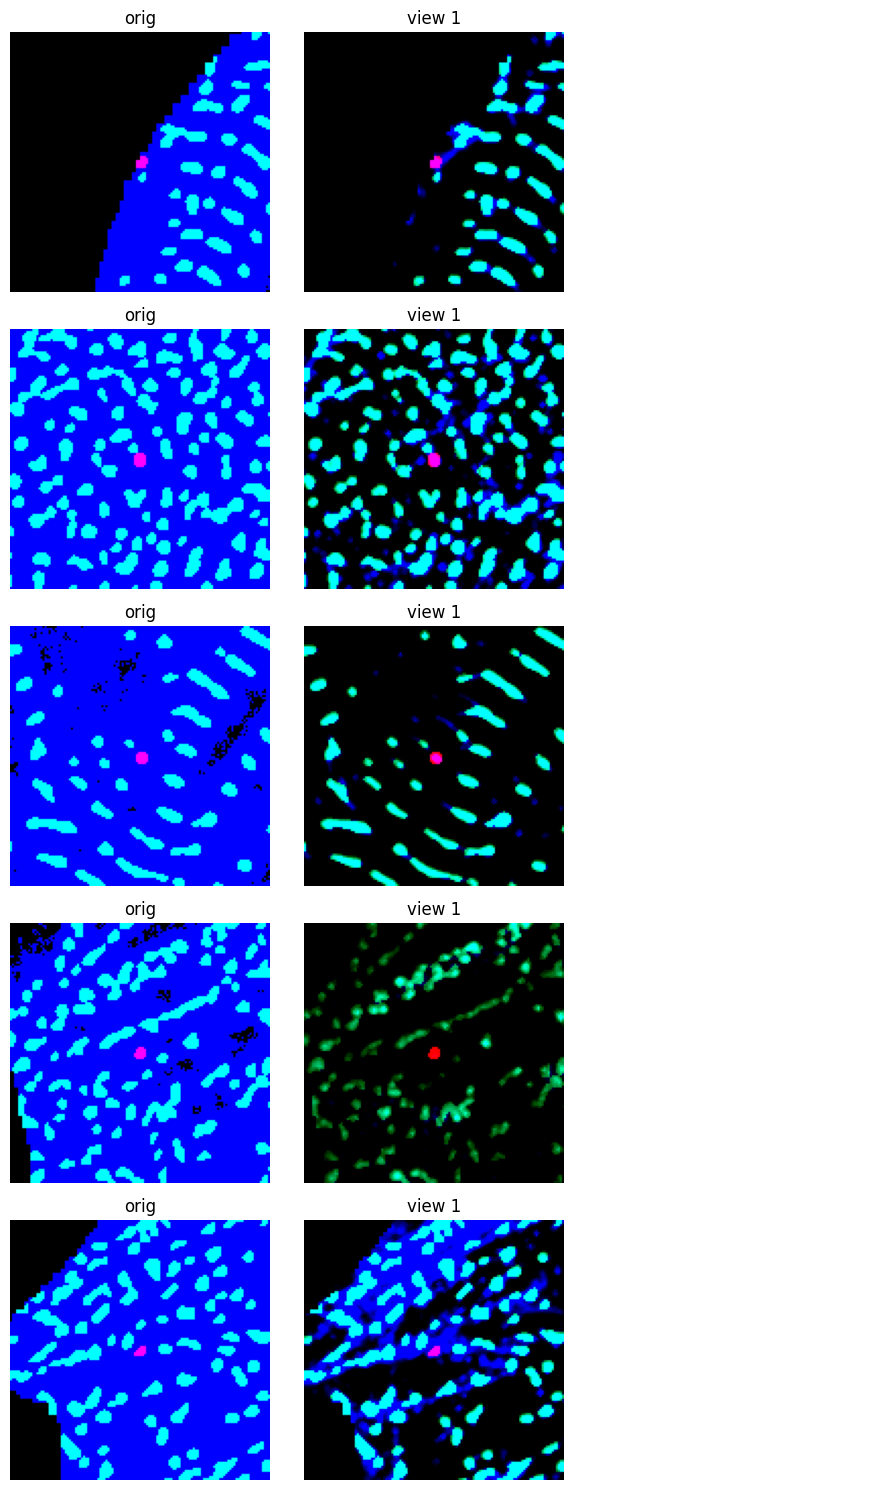

In [114]:
# Cell: Grab a batch and apply augment
# (run after you’ve already created `loader` and `ft_module`)

import matplotlib.pyplot as plt

# pull one batch
imgs, labels = next(iter(loader))      # imgs: [B, C, H, W]
# apply your training augment
aug = ft_module.augment.val          # or use your `Augment` for pretraining
view1 = aug(imgs)               # each is [B, C, H, W]

# move to CPU & numpy
view1 = view1.detach().cpu().permute(0,2,3,1).numpy()
orig  = imgs.detach().cpu().permute(0,2,3,1).numpy()

# Cell: Plot a few triplets
n = min(5, orig.shape[0])
fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
for i in range(n):
    axes[i,0].imshow(orig[i])
    axes[i,0].set_title("orig")
    axes[i,1].imshow(view1[i])
    axes[i,1].set_title("view 1")
    for ax in axes[i]:
        ax.axis("off")
plt.tight_layout()
plt.show()

In [37]:
# Config inline
class Config: pass
cfg = Config()

# Data/model
cfg.img_size    = sample_images.shape[1]
cfg.num_classes = int(sample_labels.max()) + 1
cfg.temperature = 1

# Training
cfg.epochs      = 2
cfg.seed        = 42

# Optimizer
cfg.lr           = 0.3
cfg.momentum     = 0.9
cfg.weight_decay = 1e-3

# Pretrained checkpoint path
cfg.pretrained_ckpt_path = "checkpoints/simclr-pretrain-best-train_loss_epoch=2.56.ckpt"

# Normalization (must match pretraining!)
cfg.mean          = np.mean(sample_images, axis=(0, 1, 2))
cfg.std           = np.std(sample_images, axis=(0, 1, 2))


## Step FT-3: Build & Seed

Load your pretrained encoder + first-layer projection head, seed RNG, and build the finetuning module.


In [38]:
# Instantiate
seed_everything(cfg.seed)

# load encoder + first proj-layer weights
backbone, proj_head = load_pretrained_backbone(
    cfg.pretrained_ckpt_path,
    dim_h=512,
    dim_out=128
)

# build LightningModule (fine-tunes all layers)
ft_module = FineTuningTrainer(cfg)
print("FineTuningTrainer ready. Model architecture:")
print(ft_module.model)


Global seed set to 42
/home/ghost/sarcgraph-image-revision/sarcgraph-image/classification/simclr/finetuning/core.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = 

FineTuningTrainer ready. Model architecture:
FineTunedSimCLRModel(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): SyncBatchNorm(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): SyncBatchNorm(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), 

## Step FT-4: Run Fine-tuning

We’ll save both the best and the last finetuned checkpoints with a `simclr-finetune` tag.


In [132]:
print("Number of training batches:", len(loader))
# Peek at the first batch
imgs, labels = next(iter(loader))
print("  imgs.shape =", imgs.shape, "labels.shape =", labels.shape)

Number of training batches: 13
  imgs.shape = torch.Size([8, 3, 128, 128]) labels.shape = torch.Size([8])


In [ ]:
import torch.nn.functional as F

# Load your test split (images as [N,H,W,C], labels as integer [N])
test_images = np.load("sample_data/sample_labeled_contours.npy").astype(np.float32)
test_labels = np.load("sample_data/sample_labels.npy")


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_module.to(device).eval()

# manual normalization: (img - mean) / std
mean = torch.tensor(cfg.mean, device=device).view(1,3,1,1)
std  = torch.tensor(cfg.std,  device=device).view(1,3,1,1)

# prepare images: from numpy, permute to [B,C,H,W], cast to float32, then normalize
imgs = torch.from_numpy(test_images)              # -> DoubleTensor if numpy is float64
imgs = imgs.permute(0,3,1,2).to(device).float()   # now FloatTensor
imgs = (imgs - mean) / std

with torch.no_grad():
    logits = ft_module.model(imgs)           # [N, num_classes]
    probs  = F.softmax(logits, dim=1)[:, 1]   # P(z-disc)

probs = probs.cpu().numpy()

In [9]:
print(logits)

tensor([[ 0.2901, -0.1905],
        [ 0.2944, -0.1919],
        [ 0.1782, -0.0401],
        [ 0.1586, -0.0164],
        [ 0.2838, -0.1823],
        [ 0.2191, -0.1201],
        [ 0.2893, -0.1951],
        [ 0.2943, -0.1909],
        [ 0.2939, -0.1906],
        [ 0.2784, -0.1849],
        [ 0.2893, -0.1923],
        [ 0.2912, -0.1933],
        [ 0.2916, -0.1852],
        [ 0.1798, -0.0546],
        [ 0.2216, -0.1556],
        [ 0.2934, -0.1914],
        [ 0.0626, -0.0188],
        [ 0.2709, -0.1863],
        [ 0.2951, -0.1895],
        [-0.0620, -0.0041]], device='cuda:0')


In [7]:
# Checkpoints
best_ft = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="simclr-fine-tuning-best-{val_loss:.2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=False,
)
last_ft = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="simclr-fine-tuning-last-epoch{epoch:02d}-{val_loss:.2f}",
    save_top_k=0,
    save_last=True,
)

trainer = Trainer(
    max_epochs=cfg.epochs,
    accelerator="auto",
    devices=1,
    callbacks=[best_ft, last_ft],
    log_every_n_steps=1,
)

trainer.fit(ft_module, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory checkpoints/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | model   | FineTunedSimCLRModel | 21.2 M
1 | loss_fn | CrossEntropyLoss     | 0     
-------------------------------------------------
21.2 M    Trainable params
0         Non-trainable params
21.2 M 

Epoch 0: 100%|██████████| 94/94 [00:34<00:00,  2.75it/s, loss=0.674, v_num=18, train_loss_step=0.682, train_loss_epoch=0.683]

/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)


Epoch 1: 100%|██████████| 94/94 [00:32<00:00,  2.86it/s, loss=0.665, v_num=18, train_loss_step=0.699, train_loss_epoch=0.659]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:33<00:00,  2.82it/s, loss=0.665, v_num=18, train_loss_step=0.699, train_loss_epoch=0.659]


## Step FT-5: Inference on Test Images

Run the fine-tuned SimCLR network over your hold-out set to get class probabilities for “z-disc” (class 1).


In [125]:
np.mean(imgs.cpu().numpy(), axis=(0, 2, 3)), np.std(imgs.cpu().numpy(), axis=(0, 2, 3))

(array([-8.09978922e-15, -2.36915439e-13,  1.71797837e-14]),
 array([1., 1., 1.]))

In [10]:
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_module.to(device).eval()

# manual normalization: (img - mean) / std
mean = torch.tensor(cfg.mean, device=device).view(1,3,1,1)
std  = torch.tensor(cfg.std,  device=device).view(1,3,1,1)

# prepare images: from numpy, permute to [B,C,H,W], cast to float32, then normalize
imgs = torch.from_numpy(test_images)              # -> DoubleTensor if numpy is float64
imgs = imgs.permute(0,3,1,2).to(device).float()   # now FloatTensor
imgs = (imgs - mean) / std

temp = 1
with torch.no_grad():
    logits = ft_module.model(imgs)           # [N, num_classes]
    probs  = F.softmax(logits / temp, dim=1)[:, 1]   # P(z-disc)

probs = probs.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..125.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

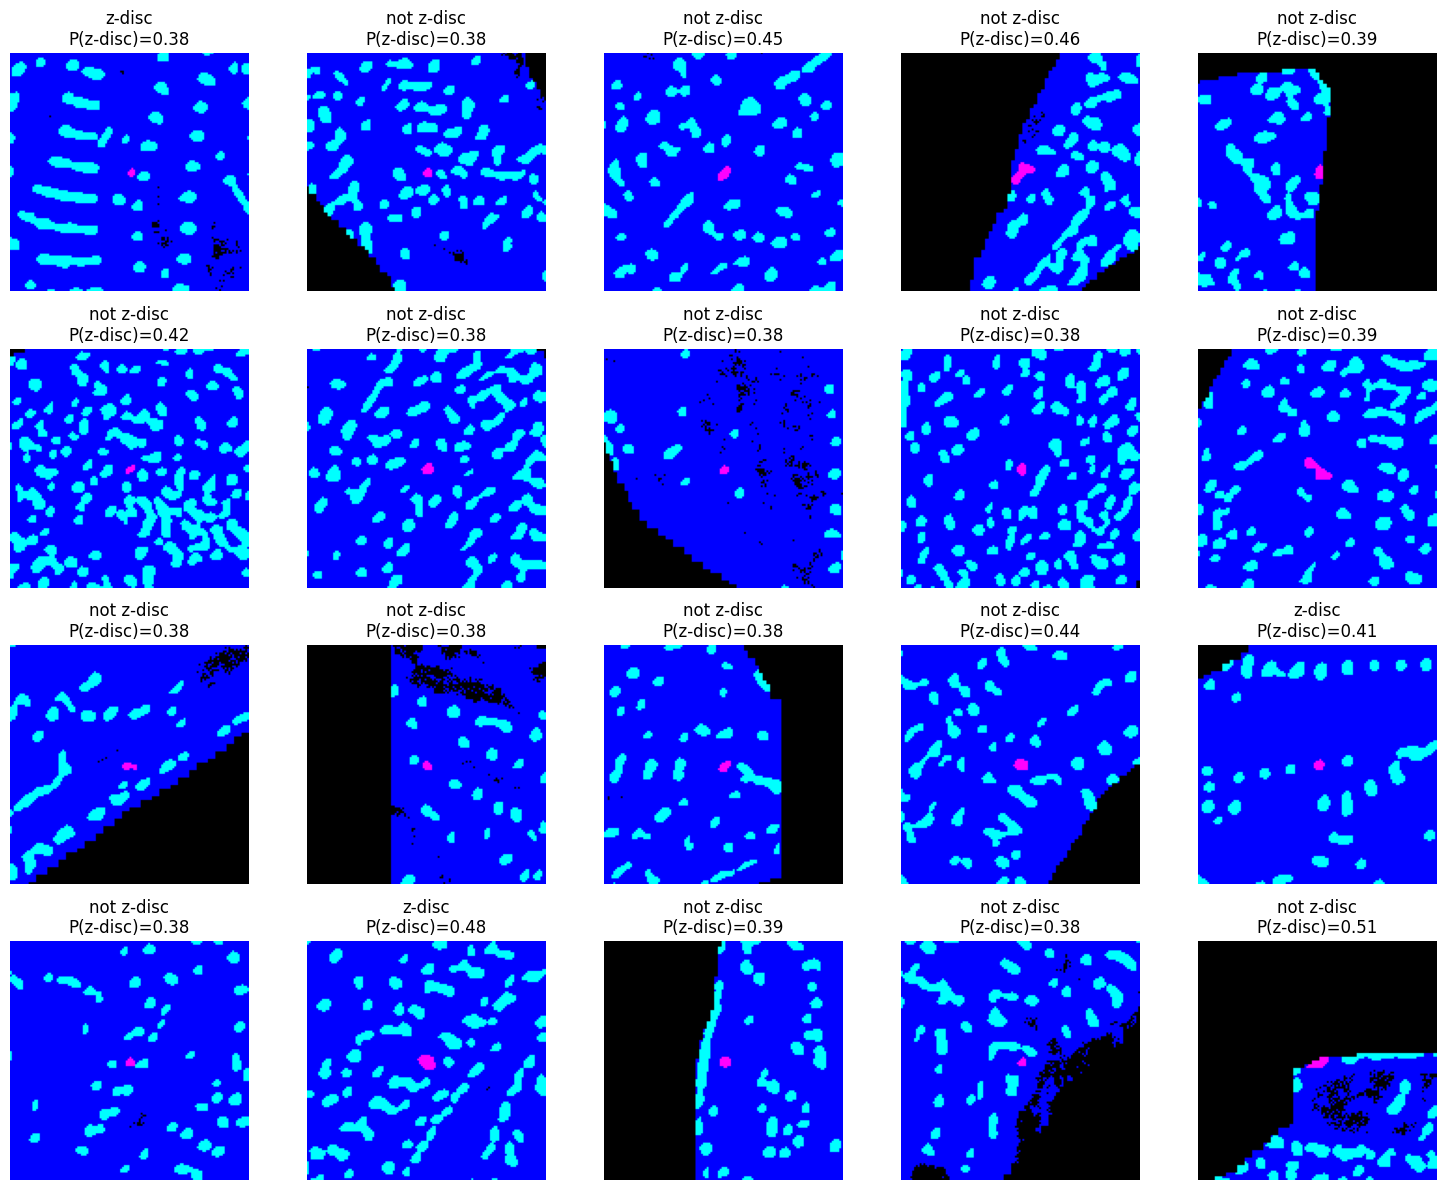

In [11]:
# Visualization
import matplotlib.pyplot as plt

n = min(20, len(test_images))
fig, axes = plt.subplots(4, 5, figsize=(15,12))
axes = axes.flatten()

for i, ax in enumerate(axes[:n]):
    img   = test_images[i]        # original [H,W,C]
    label = test_labels[i]
    prob  = probs[i]
    title = f"{'z-disc' if label==1 else 'not z-disc'}\nP(z-disc)={prob:.2f}"
    
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [12]:
import torch.nn as nn

from torchvision.models import efficientnet_v2_s
from classification.simclr.pretraining.core import ProjectionHead

backbone = efficientnet_v2_s(weights=None)
backbone.classifier = nn.Identity()
proj_head = ProjectionHead(dim_in=1280, dim_h=512, dim_out=128)

In [13]:
class FineTunedSimCLRModel(nn.Module):
    """Classifier head on pretrained SimCLR encoder+proj head."""

    def __init__(
        self, backbone: nn.Module, proj_head: nn.Module, num_classes=2
    ):
        super().__init__()
        self.backbone = backbone
        self.proj_head = proj_head
        hidden_dim = proj_head.head[-1].out_features
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.float()
        feats = self.backbone(x)
        h = self.proj_head(feats)
        return self.classifier(h)

In [14]:
model = FineTunedSimCLRModel(
    backbone=backbone, proj_head=proj_head, num_classes=cfg.num_classes
)

In [16]:
model.to(device)

# check model outputs
with torch.no_grad():
    logits = model(imgs)  # [N, num_classes]
    probs = F.softmax(logits, dim=1)[:, 1]  # P(z-disc)

In [39]:
imgs_small, labels_small = next(iter(loader))
imgs_small, lbls_small = imgs_small[:2], labels_small[:2]
small_ds  = torch.utils.data.TensorDataset(imgs_small, lbls_small)
small_ld  = DataLoader(small_ds, batch_size=2, shuffle=True)
trainer = Trainer(max_epochs=50, limit_train_batches=1.0, accelerator="auto", devices=1)
trainer.fit(ft_module, small_ld)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                 | Params
-------------------------------------------------
0 | model   | FineTunedSimCLRModel | 21.2 M
1 | loss_fn | CrossEntropyLoss     | 0     
-------------------------------------------------
21.2 M    Trainable params
0         Non-trainable params
21.2 M    Total params
84.656    Total estimated model params size (MB)
/home/ghost/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/da

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s, loss=9.91e-05, v_num=25, train_loss_step=7.04e-5, train_loss_epoch=7.04e-5]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, loss=9.91e-05, v_num=25, train_loss_step=7.04e-5, train_loss_epoch=7.04e-5]


In [40]:
ft_module.to(device).eval()
temp = ft_module.augment.val(imgs_small.to(device))
ft_module.model(temp)  # [2, num_classes]


tensor([[-4.6972,  4.4199],
        [-5.3513,  5.1335]], device='cuda:0', grad_fn=<AddmmBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..76.0].


Ground truth labels: [0, 1]
Predicted labels:   [1, 1]
Predicted probabilities:
 [[1.6880249e-05 9.9998307e-01]
 [2.0072302e-04 9.9979931e-01]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


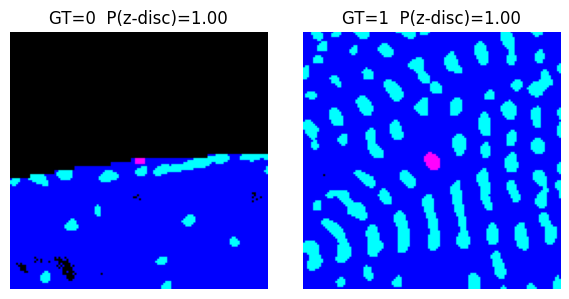

In [47]:
# Cell FT-Overfit-1: Prepare the 2-sample set
# Assume imgs_small, labels_small came from your overfit snippet
# If you didn’t save them, grab them again:
all_imgs, all_lbls = next(iter(loader))
imgs_small  = all_imgs[:2]
labels_small = all_lbls[:2]

# Move to device and set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ft_module.to(device).eval()

# Apply val-only normalization (no random crop/flip)
mean = torch.tensor(cfg.mean, device=device).view(1,3,1,1)
std  = torch.tensor(cfg.std,  device=device).view(1,3,1,1)

with torch.no_grad():
    x = imgs_small.to(device).float()
    x = (x - mean) / std
    logits = ft_module.model(x)               # [2, num_classes]
    probs  = torch.softmax(logits, dim=1)     # [2, 2]
    preds  = torch.argmax(probs, dim=1)       # [2]

print("Ground truth labels:", labels_small.tolist())
print("Predicted labels:  ", preds.cpu().tolist())
print("Predicted probabilities:\n", probs.cpu().numpy())

# Cell FT-Overfit-2: Plot the two samples
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(6,3))
for i, ax in enumerate(axes):
    img = imgs_small[i].permute(1,2,0).cpu().numpy()
    gt  = labels_small[i].item()
    p   = probs[i,1].item()
    ax.imshow(img)
    ax.set_title(f"GT={gt}  P(z-disc)={p:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# pick 2 images from your loader
imgs_small, labels_small = next(iter(loader))
imgs_small, labels_small = imgs_small[:2], labels_small[:2]
small_ds = torch.utils.data.TensorDataset(imgs_small, labels_small)
small_loader = DataLoader(small_ds, batch_size=2, shuffle=True)

trainer = Trainer(
    max_epochs=20,
    accelerator="auto",
    devices=1,
    limit_train_batches=1.0,  # use all small_loader batches each epoch
)

# monkey-patch ft_module to use this tiny loader
trainer.fit(ft_module, train_dataloaders=small_loader)

NameError: name 'lbls' is not defined

In [ ]:
# Instantiate
seed_everything(cfg.seed)

# load encoder + first proj-layer weights
backbone, proj_head = load_pretrained_backbone(
    cfg.pretrained_ckpt_path,
    dim_h=512,
    dim_out=128
)

# build LightningModule (fine-tunes all layers)
ft_module = FineTuningTrainer(cfg)
print("FineTuningTrainer ready. Model architecture:")
print(ft_module.model)